# Does Higher Risk Consistently Lead to Higher Returns

This project tests two key hypotheses derived from CAPM and sector-specific risk-return dynamics:

1.	"Stocks with a beta higher than 1.0 deliver average daily returns that are at least 20% higher than stocks with a beta lower than 1.0, consistent with the Capital Asset Pricing Model prediction."

2.	"Sector is the most important feature in determining average daily returns due to its influence on risk profiles."


### Data Access and Pre-processing:

This project uses two primary data sources:

Wikipedia (List of S&P 500 Companies):
The list of S&P 500 companies, including ticker symbols and sector classifications, was obtained from the S&P 500 [Wikipedia page](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). This information was extracted programmatically using the ```pandas.read_html()``` function.

Yahoo Finance:
Historical financial data for each S&P 500 constituent and the S&P 500 index itself (symbol: ```^GSPC```) was retrieved using the ```yfinance``` Python library. This includes daily adjusted close prices, trading volumes, and other key metrics spanning a 5 year period from January 1, 2020, to December 31, 2024.


#### Feature engineering:

Stock information
* **Symbol**:
    Each stock ticker has a unique abbreviation to represent a publicly traded company

Categorical information
* **Sector**:
    Each stock was tagged with its Global Industry Classification (GICS) sector from the Wikipedia table

Risk Metrics:
* **Beta**: Systematic risk relative to the S&P 500 using the following formula

    $ \frac{\text{Covariance of daily returns from the stock and daily returns from the benchmark}}{\text{Variance of daily returns of the benchmark}} $
* **Volatility**: Standard deviation of daily returns
* **Sharpe Ratio**: Risk adjusted returns computed using the following formula
    
    $ \frac{\text{Return of a stock} - \text{Risk-free rate}}{\text{Volatility of a stock}} $
        
    A risk-free rate of 2.3% (annualized) was assumed, and it was scaled to a daily value by dividing by 252 (trading days).

Return measures:
* **Average Daily Return**: Mean of daily percentage returns
* **Total Return**: Percentage change from the beginning to the end of the 5-year observation period
* **CAPM Expected Return**: Expected mean daily returns according to the Capital Asset Pricing Model

Stock Metrics: 
* **Trading volumes**: The average daily volume of a stock that has been traded, an indicator of liquidity

* **Market Capitalization**: The total market value of a company's outstanding shares, calculated by multiplying the stock price by the number of shares outstanding. It is used to categorize companies by size (e.g., large-cap, mid-cap, small-cap).

* **Price-to-Earnings (PE) Ratio**: A valuation ratio calculated by dividing the current stock price by the earnings per share (EPS) of the company. It is used to assess if a stock is overvalued or undervalued compared to its earnings.

* **Dividend Yield**: The annual dividend payment expressed as a percentage of the current stock price. It is an indicator of the income an investor can expect to receive relative to the stock price.

* **Debt-to-Equity (DE) Ratio**: A financial leverage ratio that compares a company’s total liabilities to its shareholders' equity. It indicates the proportion of debt used to finance the company’s assets.




Missing values were found in the PE_Ratio, Dividend_Yield and DE_Ratio columns. These specific fields are not used for hypothesis 1 so were kept in the dataset. These records were, however, dropped in the DBSCAN analysis.

No explicit normalisation was applied to the features as many of the indicators are standardised by their calculation methods. 

Outliers have been maintained for their analysis, and have only been excluded in the case of PMCC analysis.

#### Outputs

After preprocessing, the resulting dataset was stored as a CSV file named **sp500_risk_return_dataset.csv**. The final dataset contained the following features for 482 stocks:

* Symbol: Ticker symbol.
* Sector: Industry classification.
* Beta: Measure of systematic risk relative to the S&P 500.
* Volatility: Standard deviation of daily returns.
* Sharpe_Ratio: Risk-adjusted performance.
* Avg_Daily_Return: Mean of daily returns.
* Total_Return: Overall return over the 5-year period.
* Avg_Volume: Average daily trading volume.
* CAPM_Expected_Return: Average expected daily returns using the CAPM formula
* Market Cap: Total market value of outstanding shares.
* PE Ratio: Stock price relative to earnings per share.
* Dividend Yield: Annual dividend relative to stock price.
* Debt-to-Equity Ratio: Proportion of debt used to finance the company’s assets.


In [435]:
# generate_dataset.py used to create the dataset (sp500_risk_return_dataset.csv) for the project
'''
import yfinance as yf
import numpy as np
import pandas as pd

# Fetch list of S&P 500 stocks from Wikipedia
sp_assets = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_data = sp_assets[0][['Symbol', 'GICS Sector']]
sp500_data.columns = ['Symbol', 'Sector']
tickers = sp500_data['Symbol'].tolist()

# Define the benchmark (S&P 500 index)
benchmark_symbol = "^GSPC"
start_date = "2020-01-01"
end_date = "2024-12-31"
risk_free_rate = 0.016  # 1.6% annual rate

# Download benchmark data
print("Fetching benchmark data...")
benchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date, progress=False)
benchmark_returns = benchmark_data['Adj Close'].pct_change()

# Placeholder for data
summary_data = []

# Process data for each stock
print("Fetching stock data...")
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        stock_returns = stock_data['Adj Close'].pct_change()

        # Calculate risk measures
        beta = np.cov(stock_returns[1:], benchmark_returns[1:])[0, 1] / benchmark_returns[1:].var()
        volatility = stock_returns.std()

        # Calculate return measures
        avg_daily_return = stock_returns.mean()
        total_return = (stock_data['Adj Close'][-1] / stock_data['Adj Close'][0]) - 1

        # Calculate Sharpe Ratio (using risk-free rate of 2.3%)
        sharpe_ratio = (avg_daily_return - 0.023/252) / volatility if volatility != 0 else np.nan

        # Calculate CAPM Expected Return
        capm_expected_return = (risk_free_rate / 252) + beta * (benchmark_returns.mean() - (risk_free_rate / 252))

        # Average trading volume
        avg_volume = stock_data['Volume'].mean()
        
        # Other financial metrics
        stock_info = yf.Ticker(ticker).info
        market_cap = stock_info.get('marketCap')
        pe_ratio = stock_info.get('trailingPE')
        dividend_yield = stock_info.get('dividendYield')
        de_ratio = stock_info.get('debtToEquity')

        # Append results
        summary_data.append({
            'Symbol': ticker,
            'Sector': sp500_data.loc[sp500_data['Symbol'] == ticker, 'Sector'].values[0],
            'Beta': beta,
            'Volatility': volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Avg_Daily_Return': avg_daily_return,
            'Total_Return': total_return,
            'Avg_Volume': avg_volume,
            'CAPM_Expected_Return': capm_expected_return,
            'Market_Cap': market_cap,
            'PE_Ratio': pe_ratio,
            'Dividend_Yield': dividend_yield,
            'DE_Ratio': de_ratio
        })
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Convert to DataFrame and save to CSV
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("sp500_risk_return_dataset.csv", index=False)

# Display first few rows
print("Dataset generated successfully!")
print(summary_df.head())
'''

'\nimport yfinance as yf\nimport numpy as np\nimport pandas as pd\n\n# Fetch list of S&P 500 stocks from Wikipedia\nsp_assets = pd.read_html(\'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies\')\nsp500_data = sp_assets[0][[\'Symbol\', \'GICS Sector\']]\nsp500_data.columns = [\'Symbol\', \'Sector\']\ntickers = sp500_data[\'Symbol\'].tolist()\n\n# Define the benchmark (S&P 500 index)\nbenchmark_symbol = "^GSPC"\nstart_date = "2020-01-01"\nend_date = "2024-12-31"\nrisk_free_rate = 0.016  # 1.6% annual rate\n\n# Download benchmark data\nprint("Fetching benchmark data...")\nbenchmark_data = yf.download(benchmark_symbol, start=start_date, end=end_date, progress=False)\nbenchmark_returns = benchmark_data[\'Adj Close\'].pct_change()\n\n# Placeholder for data\nsummary_data = []\n\n# Process data for each stock\nprint("Fetching stock data...")\nfor ticker in tickers:\n    try:\n        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)\n        stock_return

## About the dataset

In [436]:
# Imports

import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import zscore
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [437]:
#df = pd.read_csv('filepath\sp500_risk_return_dataset.csv')
df = pd.read_csv('sp500_risk_return_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Symbol                473 non-null    object 
 1   Sector                473 non-null    object 
 2   Beta                  473 non-null    float64
 3   Volatility            473 non-null    float64
 4   Sharpe_Ratio          473 non-null    float64
 5   Avg_Daily_Return      473 non-null    float64
 6   Total_Return          473 non-null    float64
 7   Avg_Volume            473 non-null    float64
 8   CAPM_Expected_Return  473 non-null    float64
 9   Market_Cap            473 non-null    int64  
 10  PE_Ratio              451 non-null    float64
 11  Dividend_Yield        385 non-null    float64
 12  DE_Ratio              427 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 48.2+ KB


In [438]:
df.head()

,Symbol,Sector,Beta,Volatility,Sharpe_Ratio,Avg_Daily_Return,Total_Return,Avg_Volume,CAPM_Expected_Return,Market_Cap,PE_Ratio,Dividend_Yield,DE_Ratio
0,MMM,Industrials,0.776698,0.018600,0.006353,0.000209,0.050170,4.303163e+06,0.000453,82107334656,20.964186,0.0199,295.441
1,AOS,Industrials,0.816445,0.019037,0.023244,0.000534,0.558558,1.136322e+06,0.000473,9758164992,18.539946,0.0196,7.471
2,ABT,Health Care,0.756590,0.016476,0.019479,0.000412,0.415486,5.672288e+06,0.000443,221889478656,16.744764,0.0202,37.589
3,ABBV,Health Care,0.536999,0.015618,0.047490,0.000833,1.438252,6.767965e+06,0.000333,324977033216,76.945600,0.0373,1174.815
4,ACN,Information Technology,1.068085,0.018547,0.029679,0.000642,0.805200,2.311530e+06,0.000599,240778526720,32.267395,0.0170,14.127


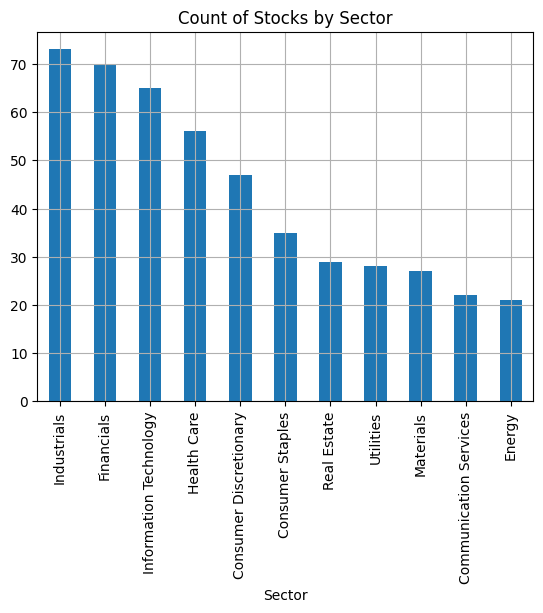

In [439]:
sector = df['Sector'].value_counts().plot(kind='bar', title="Count of Stocks by Sector", grid=True)


## Models and Analysis:
### Investigating Hypothesis 1: **“Stocks with a beta higher than 1.0 deliver average daily returns that are at least 20% higher than stocks with a beta lower than 1.0, consistent with the Capital Asset Pricing Model prediction.”**

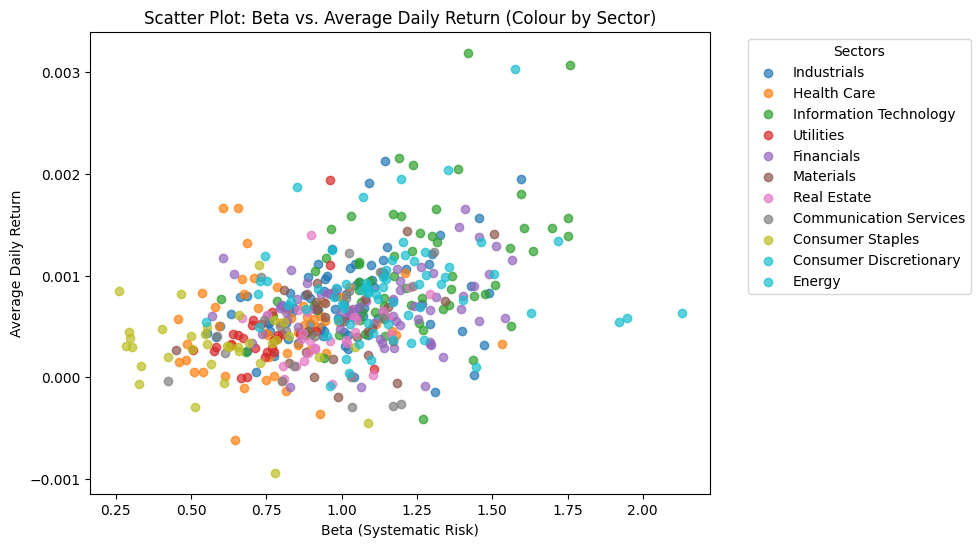

In [440]:
# Define a colormap
cmap = plt.get_cmap('tab10')

# Assign a different color to each sector
sectors = df['Sector'].unique()
sector_colors = {sector: cmap(i) for i, sector in enumerate(sectors)}

plt.figure(figsize=(8, 6))

# Plot points with sector-specific colours
for sector in sectors:
    sector_data = df[df['Sector'] == sector]
    plt.scatter(sector_data['Beta'], sector_data['Avg_Daily_Return'], alpha=0.7, color=sector_colors[sector], label=sector)
    
# Create a key for the sectors
handles, labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles, labels, title="Sectors", bbox_to_anchor=(1.05, 1), loc='upper left')    

plt.xlabel('Beta (Systematic Risk)')
plt.ylabel('Average Daily Return')
plt.title('Scatter Plot: Beta vs. Average Daily Return (Colour by Sector)')


plt.show()


Sharpe's CAPM Theorem suggests a linear relationship between a stock's beta (volatility relative to the market) and it's expected return.

#### Linear Correlation Analysis of Beta and Average Daily Return

**Person's Product Moment Correlation Coeffiecient (PMCC)** measures the strength of the linear correlation between variables

The assumptions are as follows 
* Each observation must include a pairs of values for the two variables
* The two variables must be continuous measured on an interval/ratio scale
* There is a linear relationship between the two variables
* There should be no significant outliers
* The variables should be approximately normally distrbuted


Below is the distribution of Beta and Average Daily Returns, each appearing to follow a normal distribution.

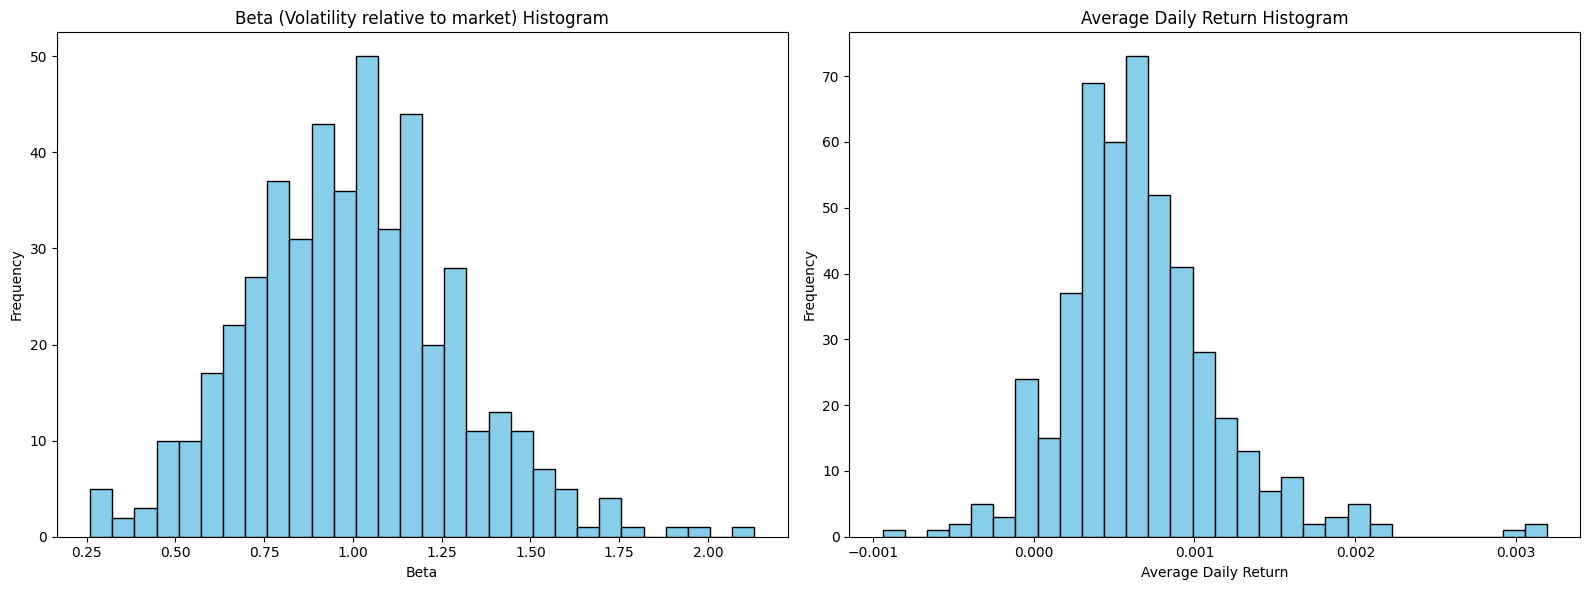

In [441]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

# Plot the Beta histogram on the first subplot
axes[0].hist(df["Beta"], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("Beta (Volatility relative to market) Histogram")
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("Frequency")

# Plot the Average Daily Return histogram on the second subplot
axes[1].hist(df["Avg_Daily_Return"], bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Average Daily Return Histogram")
axes[1].set_xlabel("Average Daily Return")
axes[1].set_ylabel("Frequency")


plt.tight_layout()
plt.show()


#### Model Optimisation

Both Beta and Average Daily Return both appear to follow a normal distribution and display a linear relationship. 
Following the prerequisites for a PMCC analysis, there appears to be significant outliers. To remove outliers, values with absolute z scores of 3 (more than 3 s.d. from mean) were excluded from the PMCC analysis.

In [442]:
beta_z_score = zscore(df['Beta'])
returns_z_score = zscore(df['Avg_Daily_Return'])

# Threshold for outliers, |z| > 3
threshold = 3

filter_df = df[(abs(beta_z_score) <= threshold) & (abs(returns_z_score) <= threshold)]

At a significance level of 0.05

Null hypothesis (H₀): ρ = 0 
    
    There is no linear relationship between Beta and Average Daily Return

Alternative hypothesis (H₁): ρ > 0
    
    There is a positive linear relationship between Beta and Average Daily Return

In [443]:
x = filter_df['Beta']
y = filter_df['Avg_Daily_Return']

# Pearson correlation
corr, pvalue = stats.pearsonr(x, y)
print(f"Pearson Correlation: {corr}, p-value: {pvalue}")

Pearson Correlation: 0.40072050370220885, p-value: 2.306217122646427e-19


##### Analysis

PMCC: 0.401 p-value = 2.306e-19  3 d.p.

p < 0.05

This is highly significant, therefore we reject the null hypothesis, implying a positive linear relationship between beta and daily average returns. 

The correlation coefficient of 0.401 indicates a moderate positive linear correlation. This indicates that to some extent, stocks with higher beta (volatility relative to the benchmark) tend to have higher average daily returns.

#### OLS Simple Linear Regression

To further model this relationship, we use linear regression to calculate the slope and intercept of the ordinary least squares (OLS) line.

In [444]:
X = df['Beta']  # Independent variable (risk relative to benchmark)
y = df['Avg_Daily_Return']  # Dependent variable (return)

# Intercept
X = sm.add_constant(X)

# Fit the regression model and display
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Daily_Return   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     95.00
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           1.43e-20
Time:                        16:14:09   Log-Likelihood:                 2976.5
No. Observations:                 473   AIC:                            -5949.
Df Residuals:                     471   BIC:                            -5941.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.774e-05   7.38e-05     -0.376      0.7

### Interpretation of Results

#### Model Summary

R-squared: 0.168, Adj. : 0.166

* This suggests that 16.8% (16.6 adj) of the variability in Average Daily Return is explained by Volatility. This effect size is moderate and suggests that market beta is a significant predictor of returns but other factors outside of this model could also play a role


F-statistic: 95.18, Probability: 1.43e-20

* The F-statistic of 95.00 is considered large and the probability is significant. We reject a null hypothesis (H0 assumes that all regression coefficients are zero) and conclude that at least one predictor contributes significantly to Average Daily Returns. In this case, there is only one predictor and therefore Beta contributes signifcantly to average daily returns.

The Coefficients:

* The slope of the regression line suggests that **for every 1% increase in Beta there is a 0.07% increase in Average Daily Return**

The constant (intercept) is statistically insignificant (p = 0.707), and therefore when beta is 0, the expected return is not meaningfully different from 0, which aligns with financial theory - cash is considered to have a beta of 0.

The line of regression is:

        Avg_Daily_Return = 0.0007 * Beta 

The distribution of residuals:

* The Omnibus test and Jarque-Bera(JB) test statistics appear to indicate a skew in residuals. The skew of 0.730 suggests a positive skew in the distribution of residuals, suggesting there are more extreme positive residuals. The JB test has a p-value of 6.47e-50, rejecting the null hypothesis of normality.

This suggests that the relationship between the independent and dependent variables might not be fully captured by a linear model, opposing the CAPM model.

**Future work could explore additional predictors to improve the model.**

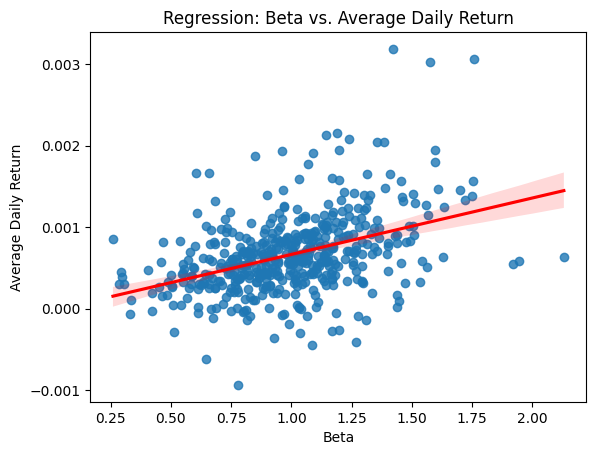

In [445]:
# Scatter plot with regression line
sns.regplot(x='Beta', y='Avg_Daily_Return', data=df, line_kws={'color': 'red'})
plt.title('Regression: Beta vs. Average Daily Return')
plt.xlabel('Beta')
plt.ylabel('Average Daily Return')
plt.show()

Interpretation: The regression model indicates that there is a positive relationship between volatility (Beta) and average daily return. The faint highlight surrounding shows the 95% confidence interval of the true regression line.

By analysing the residuals against predicted values, we can determine whether a linear model is a good fit for the data.

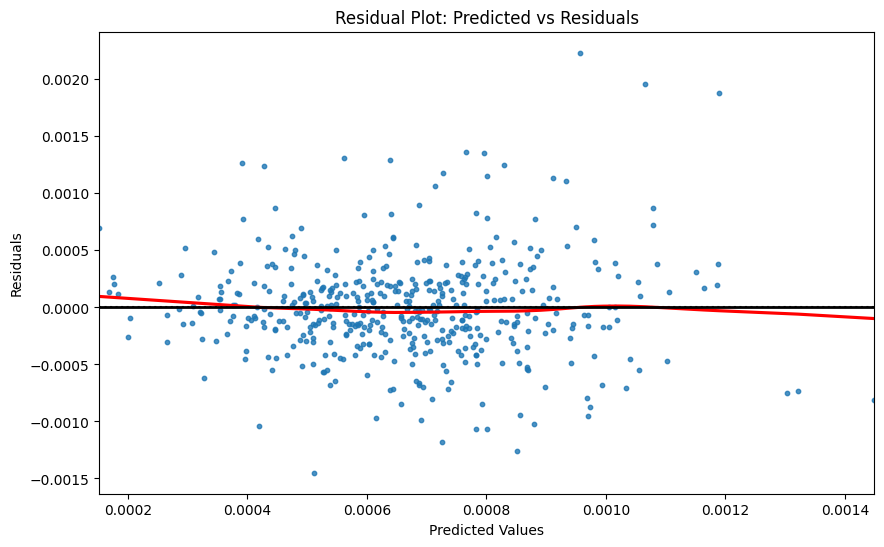

In [446]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the predicted values
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'}, scatter_kws={'s': 10})
plt.axhline(0, color='black', lw=2) 
plt.title('Residual Plot: Predicted vs Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


The red line determines a trend in the residuals - for the most part this is close to horizontal, however deviates at the extreme low and high predicted values. This suggests the linear model between systematic risk and returns may not capture the full complexity of the data.

#### In reference to the CAPM Theorem

Given the moderate effect size and the R squared statistic of 16.8% for beta as a predictor of average daily returns, it does not appear that systematic risk is linearly correlated to higher returns in the **way proposed in the CAPM theorem**. The CAPM formula has beta as a variable while all other factors remain as constants - if this were the case, we would expect a larger effect size. Higher systematic risk is associated with higher returns as expected, however beta alone does not model a linear relationship.

    Average Daily Return ~ Beta

**Hypothesis 1: “Stocks with a beta higher than 1.0 deliver average daily returns that are at least 20% higher than stocks with a beta lower than 1.0, consistent with the Capital Asset Pricing Model prediction.”**

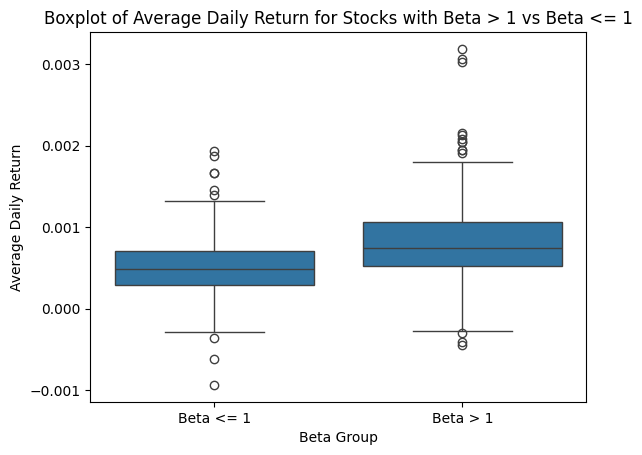

In [447]:
# beta_bin data frame is used for Hypothesis 1

df_beta_bin = df.copy()
df_beta_bin['Beta_Group'] = df_beta_bin['Beta'].apply(lambda x: '1' if x > 1 else '0')

sns.boxplot(x='Beta_Group', y='Avg_Daily_Return', data=df_beta_bin)

plt.title('Boxplot of Average Daily Return for Stocks with Beta > 1 vs Beta <= 1')
plt.xlabel('Beta Group')
plt.ylabel('Average Daily Return')

plt.xticks(ticks=[0, 1], labels=['Beta <= 1', 'Beta > 1'])

plt.show()

The boxplot shows higher beta stocks with a higher mean of returns than lower beta stocks. The higher beta stocks also have more positive outliers and a larger interquartile range, showing a greater spread of data around the median. Daily return is more consistent for stocks of lower beta.

### Analysis of Variance (ANOVA) for low and high beta

In [448]:
# Group the data into two categories: Beta > 1 and Beta <= 1
high_beta = df[df['Beta'] > 1]['Avg_Daily_Return']
low_beta = df[df['Beta'] <= 1]['Avg_Daily_Return']

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(high_beta, low_beta)

# Display the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

F-statistic: 50.14298397958193
P-value: 5.228923955953558e-12
There is a significant difference between the two groups.


#### T test to compare the means of the two groups

In [449]:
# Calculate the means of Avg_Daily_Return for each low and high beta group
high_beta = df_beta_bin[df_beta_bin['Beta_Group'] == '1']['Avg_Daily_Return']
low_beta = df_beta_bin[df_beta_bin['Beta_Group'] == '0']['Avg_Daily_Return']

# Perform independent t-test
t_stat, p_value = ttest_ind(high_beta, low_beta, equal_var=False)  

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Calculate the mean difference
mean_diff = high_beta.mean() - low_beta.mean()

# Calculate standard errors
se_high = high_beta.std() / np.sqrt(len(high_beta))
se_low = low_beta.std() / np.sqrt(len(low_beta))
se_diff = np.sqrt(se_high**2 + se_low**2)

# 95% Confidence Interval for the difference in means
ci_lower, ci_upper = mean_diff + stats.t.ppf([0.025, 0.975], df=len(high_beta) + len(low_beta) - 2) * se_diff

# Percentage change for the mean difference lower bound
percent_change = (ci_lower / low_beta.mean()) * 100

print()
print(f"Mean Difference: {mean_diff}")
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")
print()
print(f"Percentage Change: {percent_change:.2f}%")

T-statistic: 7.086177220945226
P-value: 5.7703771883975595e-12

Mean Difference: 0.0003043392130226641
95% Confidence Interval: (0.00021994524240787284, 0.0003887331836374554)

Percentage Change: 43.06%


In reference to 

**Hypothesis 1: “Stocks with a beta higher than 1.0 deliver average daily returns that are at least 20% higher than stocks with a beta lower than 1.0, consistent with the Capital Asset Pricing Model prediction.”**

##### Analysis of Variance and T-statistic tests

The one-way ANOVA analysis indicates a significant difference between the returns of the low and high beta groups. 

The t statistic quantifies the difference between the means of the two groups. The mean difference is observed as 0.000304 (3 s.f.), in the 95% percent confidence interval, with the true absolute mean likely to lie between 0.000220 and 0.000389. The p value, 5.770e-12 is statistically significant reinforcing that the mean returns of higher beta stocks is significantly higher than that of lower beta stocks.

Taking the lower bound of the confidence interval, the mean difference as a percentage of the mean of the lower beta group is 43.06%. Since this exceeds the 20% increase stated in the hypothesis, we can confidently conclude that Hypothesis 1 is supported by the data. Stocks with a beta higher than 1.0 deliver significantly higher average daily returns compared to stocks with a beta lower than or equal to 1.0. 

However this is unlikely to be entirely consistent with the Capital Asset Pricing Model prediction as the variable beta alone does not reflect a linear relationship with average daily returns. 

### Investigating Hypothesis 2

**Sector is the most important feature in determining average daily returns due to its influence on risk profiles.**


#### Box plots for volatily and beta by sector

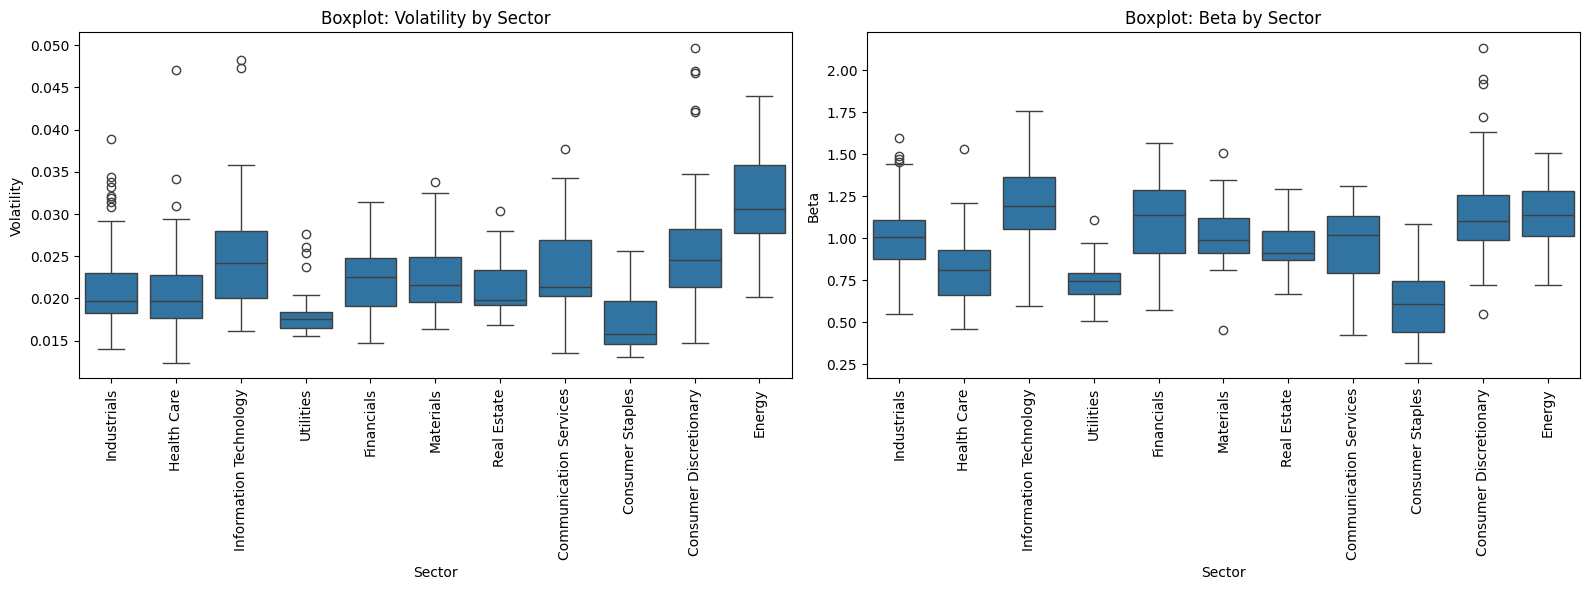

Sector
Communication Services    0.940881
Consumer Discretionary    1.166521
Consumer Staples          0.597042
Energy                    1.127928
Financials                1.101645
Health Care               0.809290
Industrials               1.011678
Information Technology    1.211372
Materials                 1.014290
Real Estate               0.963756
Utilities                 0.757845
Name: Beta, dtype: float64


In [450]:
# Side by side view of the two boxplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for Volatility by Sector
sns.boxplot(x='Sector', y='Volatility', data=df, ax=axes[0])
axes[0].set_title('Boxplot: Volatility by Sector')
axes[0].set_xlabel('Sector')
axes[0].set_ylabel('Volatility')
axes[0].tick_params(axis='x', rotation=90)

# Boxplot for Beta by Sector
sns.boxplot(x='Sector', y='Beta', data=df, ax=axes[1])
axes[1].set_title('Boxplot: Beta by Sector')
axes[1].set_xlabel('Sector')
axes[1].set_ylabel('Beta')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.show()

print(df.groupby('Sector')['Beta'].mean())


The box plots represent the distribution of data for volality and beta (volatility relative to the benchmark) by Sector. 

**Key observations:**

* The most volatile sectors (beta), by mean are Information Technology (1.211372), Consumer Discretionary (1.166521) and Energy (1.127928)

* Energy has the highest volatility which is significantly lower when adjusted to the benchmark. This indicates that energy fluctuations likely move with the market

* Information Technology has a high volatility and beta mean

* Industrials and Consumer Discretionary have a notable number of outliers, with more signficantly more volatility than the rest of the group

* Utilities has a relatively low level of volatility and the values largely remain consistent, shown by the smaller interquartile range


**The contrast in risk profiles across sectors suggest that Sector could be a significant indicator of risk and therefore of returns**


#### Multiple Linear Regression Model - Model Optimisation

Adding to the linear model from earlier, the medium effect size of the R squared statistic has prompted further exploration into additional predictors that may improve the model. Initially, Sector will be one hot encoded to act as an additional variable to the linear model. Within a sector, there is the assumption that companies have similar risk return profiles so the AIC (previosuly -5949) will be observed to indicate a better/worse fit.

**New Linear Model**: 
Average Daily Return ~ Beta + Sector

In [451]:
# Average Daily Return ~ Beta + Sector 
model = smf.ols('Avg_Daily_Return ~ Beta + C(Sector)', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Daily_Return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     13.67
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           9.21e-23
Time:                        16:14:11   Log-Likelihood:                 2999.8
No. Observations:                 473   AIC:                            -5976.
Df Residuals:                     461   BIC:                            -5926.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

#### Comparing the Simple Linear Regression to Multiple Linear Regression
The R Squared Statistic has increased from 16.8% to 24.6% indicating that Sector is an additional factor in predicting returns. 
The AIC value has lowered from -5949 to -5976, showing a better fit for the model.

Observations:

Significant coefficients (Significance Level: 0.05) include the following sectors

* (coef: 0.0005 p-value: 0.000) Beta

* (coef: 0.0004 p-value: 0.000) Information Technology

* (coef: 0.0005 p-value: 0.001) Energy 

* (coef: 0.0002 p-value: 0.029) Industrials

In addition to beta, these 3 sectors contribute signfiicantly to the regression model in determining average daily returns.

The **significant positive coefficients for Information Technology, Energy and Industrials** suggest that companies in these sectors tend to perform better in terms of daily returns. The improved AIC score indicates that adding the sector variable enhances the model's ability to capture differences in risk-return profiles across sectors, highlighting how sector-specific factors contribute to the variation in returns.

**Furthermore adding an interaction term between Beta and Sector can examine if the relationship between Beta and average daily returns differs by sector.**


**New Linear Model**: 
Average Daily Return ~ Beta * Sector


In [452]:
# Average Daily Return ~ Beta * Sector
model = smf.ols('Avg_Daily_Return ~ (Beta * C(Sector))', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Daily_Return   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     8.238
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           2.27e-21
Time:                        16:14:11   Log-Likelihood:                 3009.9
No. Observations:                 473   AIC:                            -5976.
Df Residuals:                     451   BIC:                            -5884.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Multiple Linear Regression with **Interaction Term**

The R Squared Statistic has slightly increased from 24.6% to 27.7% indicating that Sector modeled as an interaction term explains a higher proportion of returns. The effect size remains moderate, suggesting the exploration of more predictors. 

The AIC value has of -5976, has been maintained, showing a similar fit.

This slight improvement in the R squared statistic captures the industry-specific differences in how beta impacts returns. 

**The coefficients modeled here, however, are not statistically significant, suggesting further investigation into the drivers of return**

### Random Forest Feature Importance

In [453]:
df_cleaned = df.dropna()

# Uses One-Hot Encoding to convert the 'Sector' column into multiple binary columns
sector_encoded = pd.get_dummies(df_cleaned['Sector'], prefix='Sector')
df_cleaned = pd.concat([df_cleaned, sector_encoded], axis=1)
df_cleaned = df_cleaned.drop(columns=['Sector'])

print(df_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 0 to 471
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Symbol                         335 non-null    object 
 1   Beta                           335 non-null    float64
 2   Volatility                     335 non-null    float64
 3   Sharpe_Ratio                   335 non-null    float64
 4   Avg_Daily_Return               335 non-null    float64
 5   Total_Return                   335 non-null    float64
 6   Avg_Volume                     335 non-null    float64
 7   CAPM_Expected_Return           335 non-null    float64
 8   Market_Cap                     335 non-null    int64  
 9   PE_Ratio                       335 non-null    float64
 10  Dividend_Yield                 335 non-null    float64
 11  DE_Ratio                       335 non-null    float64
 12  Sector_Communication Services  335 non-null    bool   


In [454]:
targets = df_cleaned["Avg_Daily_Return"]
final_features = df_cleaned.drop(columns=['Avg_Daily_Return', 'CAPM_Expected_Return', 'Symbol', 'Total_Return', 'Sharpe_Ratio'])

xtrain, xtest, ytrain, ytest = train_test_split(final_features,targets,random_state=2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape


((251, 18), (84, 18), (251,), (84,))

In [455]:
# Initialize the Random Forest Regressor and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(xtrain, ytrain)

RandomForestRegressor(random_state=42)

In [456]:
# Predict on test data
ypred = rf_model.predict(xtest)

# Calculate metrics
mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 8.942680887181602e-08
R-squared: 0.43153896608618836


The mean squared error suggests that predictions are close to the actual values.

The R squared statistic suggests that 43.15% of the variation in average daily return is explained by this Random Forest model. This is a moderate value but still leaves a substantial proportion unexplained.

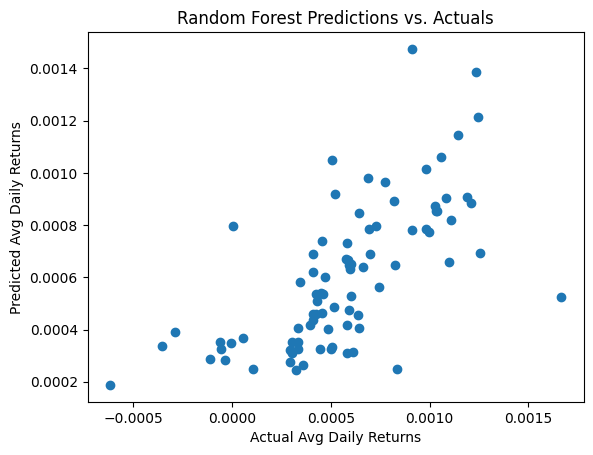

In [457]:
# Visual interpretation

plt.scatter(ytest, ypred)
plt.xlabel('Actual Avg Daily Returns')
plt.ylabel('Predicted Avg Daily Returns')
plt.title('Random Forest Predictions vs. Actuals')
plt.show()

In [458]:
required_columns = rf_model.feature_names_in_
df_cleaned_aligned = df_cleaned[required_columns]

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': df_cleaned_aligned.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


                          Feature  Importance
1                      Volatility    0.263699
5                  Dividend_Yield    0.199282
0                            Beta    0.163684
4                        PE_Ratio    0.115269
3                      Market_Cap    0.095291
6                        DE_Ratio    0.061997
2                      Avg_Volume    0.053641
10                  Sector_Energy    0.010106
12             Sector_Health Care    0.008439
14  Sector_Information Technology    0.006379
13             Sector_Industrials    0.004566
11              Sector_Financials    0.004395
9         Sector_Consumer Staples    0.003645
8   Sector_Consumer Discretionary    0.003318
15               Sector_Materials    0.002014
17               Sector_Utilities    0.001992
7   Sector_Communication Services    0.001195
16             Sector_Real Estate    0.001086


The most important features in determining average daily returns in this model are Volatility, Dividend Yield and Beta. Financial indicators have stronger predictive capability than Sector. Beta and non volatility (not benchmarked) have already been established as indicators of high return, as well as dividend yield referring to income from share ownership, which is decided by a company's board of directors. 

From this dataset, Sector does not appear to be the most important feature in determining average daily returns.

